# CQF Exam Two

## January 2024 Cohort

## Task (copied from the exam sheet)

Use the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$

$$
V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right]
$$

for the appropriate form of payoff, to consider **Asian** and **Lookback** options.

Use the **Euler-Maruyama** (only) scheme for initially simulating the underlying stock price. As an initial example you may use the following set of sample data:

\begin{align*}
\text{Today's stock price } S_0 & = 100 \\
\text{Strike } E & = 100 \\
\text{Time to expiry } (T - t) & = 1 \text{ year} \\
\text{Volatility } \sigma & = 20\% \\
\text{Constant risk-free interest rate } r & = 5\%
\end{align*}

Then vary the data to see the affect on the option price.

## Solution

### 1 Mathematical formulation

Under risk neutrality, we assume the underlying stock price process $S_t$ follows a Geometric Brownian motion

$$dS_t = rS_t dt + \sigma S_t dW_t,$$

where $S_t$ is the price of the underlying at time $t$, $\sigma$ is constant volatility, $r$ is the constant risk-free interest rate, and $W_t$ is the Brownian motion.

Following [1] + [2], Euler-Maruyama method discretizes the process $S_t$ over the time steps $\delta t$ in the time interval $0 < \delta t < T$ to

$$S(t+\delta t) = S(t) * \left(1+ r\delta t+\sigma  \sqrt{\delta t}\phi\right),$$

where $\phi$ is from a standardized Normal distribution. But since our SDE for the asset path is integrable, we can find the time-stepping algorithm

$$S(t+\delta t) = S(t) * \exp\left[\left(r-\frac{1}{2}\sigma^2\right)\delta t + \sigma\sqrt{\delta t}\phi\right],$$

which is what we will implement in the following.

In [121]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


np.set_printoptions(precision=3)
pd.set_option('display.precision', 4)
warnings.filterwarnings('ignore')

In [122]:
S0 = 100
K = 100  # using K for strike seems more natural for me, so I named this variable K
t = 1
sigma = 0.2
r = 0.05
dt = 0.01
number_of_mc_paths = 50000

### 2 Generate price paths

Now generate $N=50k$ Monte Carlo asset paths using the discretized time-stepping algorithm for Geometric Brownian motion and store these asset simulations in an array S. Each of these 50k simulations of S will contain $(T-t)/0.01 = 100$ stock prices for each time step $\delta t$ over the course of the observation period until the derivative options expire.

It makes sense to have a high number of Monte Carlo paths (in this case: $N=50000$), because the sources in the Monte Carlo pricing method are of order $\mathcal{O}(N^{-0.5})$. The time step size $\delta t$ should also be chosen as small as possible, since the discretization of continuous events always introduces some imprecisions of order $\mathcal{O}(\delta t)$.

In [110]:
def simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths=10000):
    """Simulate stock price using Euler-Maruyama method."""
    N = int(t / dt)  # number of time steps
    S = np.zeros((number_of_mc_paths, N))
    S[:, 0] = S0
    for i in range(1, N):
        dW = np.random.standard_normal(number_of_mc_paths)  # Brownian increment
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * dW)  # Euler-Maruyama step
    return S


S = simulate_stock_price(S0, r, sigma, t, dt, number_of_mc_paths)
# S is an array with length = <number_of_mc_paths> containing the simulated asset prices
S

array([[100.   , 102.687, 100.724, ...,  81.126,  83.717,  82.36 ],
       [100.   , 103.526, 105.479, ..., 103.624, 104.91 , 104.746],
       [100.   ,  98.384,  98.238, ..., 105.19 , 108.558, 105.838],
       ...,
       [100.   ,  98.975,  99.59 , ...,  99.102, 102.505, 105.101],
       [100.   ,  96.986,  94.923, ..., 112.574, 117.419, 118.823],
       [100.   ,  98.114,  96.975, ...,  89.838,  88.877,  88.568]])

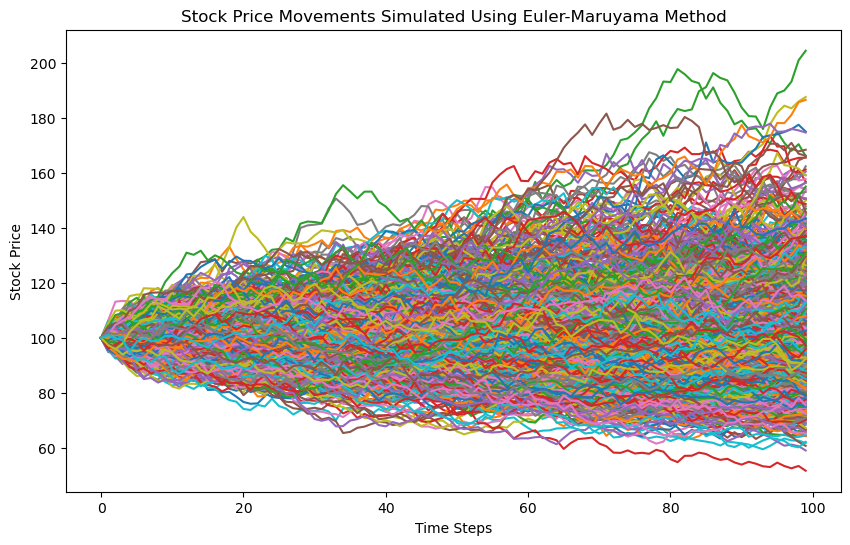

In [111]:
plt.figure(figsize=(10, 6))
for i in range(1000):  # plot the first 1000 paths
    plt.plot(S[i, :])
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Movements Simulated Using Euler-Maruyama Method')
plt.show()

### 3 From asset price to option price

With our asset price simulations generated, we can now calculate the option payoff at expiry, i.e. $\textbf{Payoff}(S_T)$, for every path. This yields $N$ option payoffs for each option type. Under risk-neutral measure $\mathbb{Q}$, the option price at any time $0\leq t\leq T$ is the discounted value of the expected payoff we apply the formula, i.e.

$$V(S, t) = e^{-r(T-t)} \mathbb{E}^\mathbb{Q}\left[\textbf{Payoff}(S_T)\right].$$

We will now implement this formula for **Asian options** and **Lookback options**.

##### Asian options
Asian options depend on the average price of the underlying price $S_t$ for $0<t<T$. Denote this average price by $A$. It follows that
* Asian call payoff = $\max(A-E, 0)$
* Asian put payoff = $\max(E-A, 0)$.

##### Lookback options
Lookback options depend on the maximum price $M$ or minimum price $m$ of the underlying price $S_t$ for $0<t<T$. For a fixed strike $E$, the payoff functions are given by
* Lookback call payoff, fixed strike = $\max(M-E, 0)$
* Lookback put payoff, fixed strike = $\max(E-m, 0)$.

Lookback options with so-called floating strike have payoffs

* Lookback call payoff, floating strike = $\max(S_T-m, 0)=S_T-m$
* Lookback put payoff, floating strike = $\max(M-S_T, 0)=M-S_T$.

In [123]:
def asian_option(S, K, r, t):
    """Calculate Asian call + put option prices by discounting their expected payoffs."""
    avg = np.mean(S, axis=1)  # mean stock price over the path
    asian_call = np.exp(-r * t) * np.maximum(avg - K, 0)
    asian_put = np.exp(-r * t) * np.maximum(K - avg, 0)
    return np.mean(asian_call), np.mean(asian_put)


def lookback_option(S, K, r, t, fixed_strike=1):
    """Calculate Lookback call + put option prices by discounting their expected payoffs."""
    min_S = np.min(S, axis=1)  # minimum stock price over all simulations
    max_S = np.max(S, axis=1)  # maximum stock price over all simulations
    if fixed_strike:
        lookback_call = np.exp(-r * t) * np.maximum(max_S - K, 0)
        lookback_put = np.exp(-r * t) * np.maximum(K - min_S, 0)
    else:  # calculate the option payoffs for floating strike now
        lookback_call = np.exp(-r * t) * np.maximum(S[:, -1] - min_S, 0)
        lookback_put = np.exp(-r * t) * np.maximum(max_S - S[:, -1], 0)
    return np.mean(lookback_call), np.mean(lookback_put)

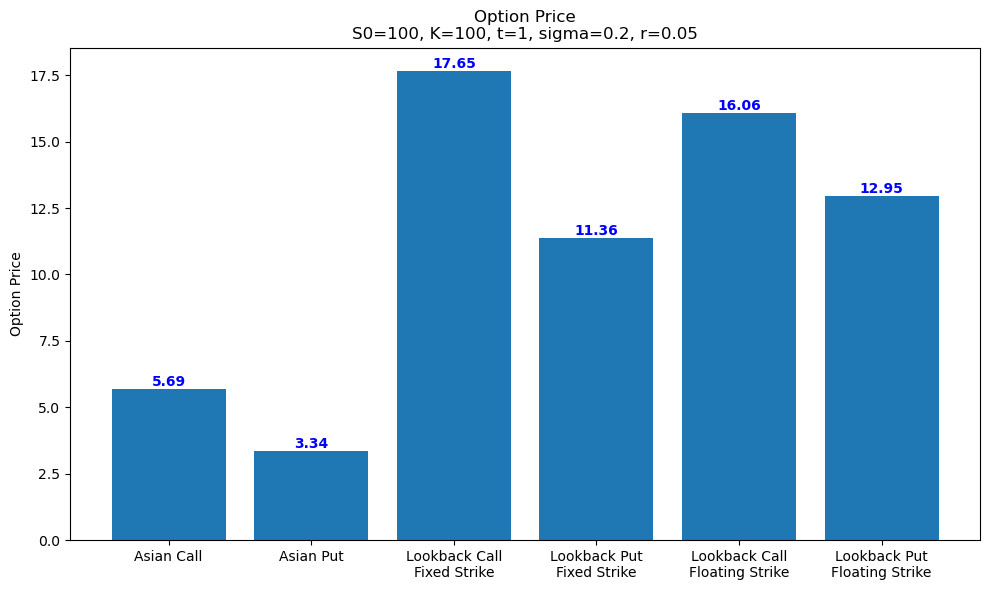

In [124]:
# Calculate option prices + plot them in a bar diagram
asian_call, asian_put = asian_option(S, K, r, t)
lookback_fixed_call, lookback_fixed_put = lookback_option(S, K, r, t, fixed_strike=1)
lookback_float_call, lookback_float_put = lookback_option(S, K, r, t, fixed_strike=0)

plt.figure(figsize=(10, 6))
labels = ['Asian Call', 'Asian Put',
          'Lookback Call\nFixed Strike', 'Lookback Put\nFixed Strike',
          'Lookback Call\nFloating Strike', 'Lookback Put\nFloating Strike']
prices = [asian_call, asian_put, lookback_fixed_call, lookback_fixed_put, lookback_float_call, lookback_float_put]
bars = plt.bar(labels, prices)

# Annotate bars with prices
for bar in bars:
    option_price = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, option_price + 0.01, round(option_price, 2),
             ha='center', va='bottom', color='blue', weight='bold')

plt.ylabel('Option Price')
plt.title(f'Option Price\nS0={S0}, K={K}, t={t}, sigma={sigma}, r={r}')
plt.xticks()
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()

### 4 Analysis of option prices given $S_0=K=100, T-t=1 year, \sigma=20\%, r=5\%, \delta t=0.01, N=50000$

This plot shows that lookback options (both call and put) are the most expensive to purchase, while the Asian options are cheaper. This can be explained intuitively because the average function is more less volatile and stabilizing than the maximum or minimum functions that the lookback options depend on. Therefore, being able to exercise depending on the maximum or minimum of the stock price over a certain time interval versus on the average on the same time interval has much higher upside potential for the investor which is reflected in the higher prices.

We can also plot the three functions compared to the asset simulations. Note that the maximum and minimum function might look wrong upon first inspection, but we only plot the first 500 simulation paths of $N=50k$ for performance and also visibility of the plot.

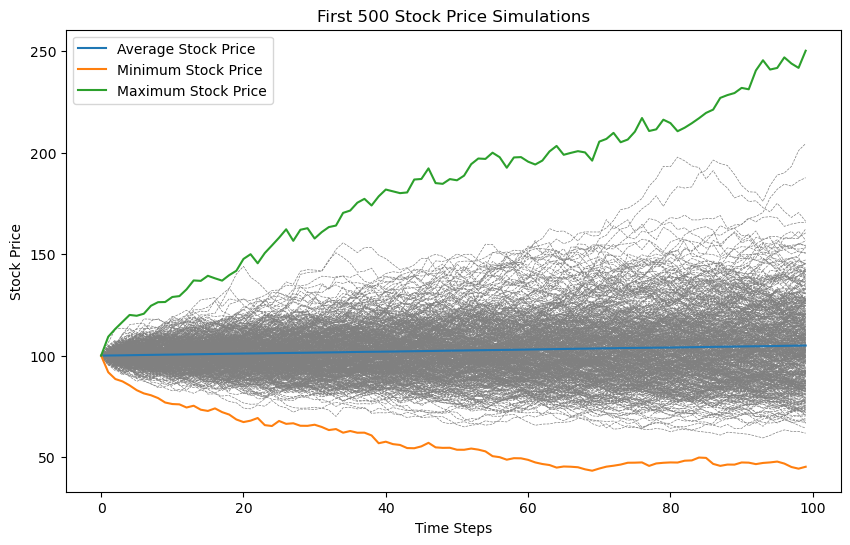

In [118]:
plt.figure(figsize=(10, 6))
for i in range(500):  # plot the first 1000 paths
    plt.plot(S[i, :], color='gray', linewidth=0.5, linestyle='dashed')

# plot other functions of the stock price simulations, like average, min + max
avg_S = np.mean(S, axis=0)
min_S = np.min(S, axis=0)
max_S = np.max(S, axis=0)
plt.plot(avg_S, label='Average Stock Price')
plt.plot(min_S, label='Minimum Stock Price')
plt.plot(max_S, label='Maximum Stock Price')

plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title(f'First 500 Stock Price Simulations')
plt.legend()
plt.show()

### 5 Impact analysis of parameters $S_0,K,T-t,\sigma,r=5\%,\delta t,N$

## References

* [1]: JA243.4: Lecture Notes on Numerical Methods by Dr. Riaz Ahmad, CQF Faculty, Head of Faculty
* [2]: JA24 Monte Carlo Simulation: CQF Python Labs on Monte Carlo Simulation by Kannan Singaravelu